# **Trabalho pratico - IA Jogo da Velha**

Notebook contendo os algoritmos de busca em largura, profundidade, gulosa, ordenada e A* gerando a árvore solução que é apresentada visualmente pela utilização da biblioteca Graphviz.

Neste jogo da velha, a IA será entendida como o jogador das bolas (O). Portanto, consideramos o encerramento do jogo apenas em condições que O seja o vencedor.

Ctrl+F9 (Run all) executa todas as buscas.

In [ ]:
!pip install graphviz

In [ ]:
import graphviz

ps = graphviz.Digraph('tic-tac-toe', comment='Tic-tac-toe solution tree', strict=True)

Importando time para medir o tempo de cada busca e anotar altura das soluções:

In [ ]:
import time

timers = {}
alturas = {}

Implementando as funções que seram resposaveis por encontrar o final de jogo para a maquina:

In [ ]:
def game_winner(board, symbol):
  if board[0][0] == board[0][1] == board[0][2] == symbol:
    return True
  elif board[1][0] == board[1][1] == board[1][2] == symbol:
    return True
  elif board[2][0] == board[2][1] == board[2][2] == symbol:
    return True
  elif board[0][0] == board[1][1] == board[2][2] == symbol:
    return True
  elif board[0][2] == board[1][1] == board[2][0] == symbol:
    return True
  elif board[0][0] == board[1][0] == board[2][0] == symbol:
    return True
  elif board[0][1] == board[1][1] == board[2][1] == symbol:
    return True
  elif board[0][2] == board[1][2] == board[2][2] == symbol:
    return True

  return False

def goal_find(board):
  s1 = game_winner(board, 'X')
  s2 = game_winner(board, 'O')

  if s2 == False and s1 == False:
    for line in board:
      for col in line:
        if col == '':
          # Ainda existem casas vazias para tentar
          return False
  
  # Oponente venceu
  if s1 == True:
    return False

  # IA venceu (goal atingido, o que queremos)
  if s2 == True:
    return True

  # Deu velha (empatou)
  return False

Classe que representa um no na arvore de busca, armazenando os seguintes dados:

- childs: nós filhos.
- matrix: a matriz que representa o nó.
- label: o template para o graphviz.
- id_ref: id do nó (inteiro).
- id_name: id do nó em string.
- i, j: localização no tabuleiro.
- childTurn: turno do filho.
- parent: pai do nó.
- heuristic: valor que a função h(n) retornou para este nó.
- cost: valor que a função g(n) retornou para este nó.
- A: valor que a função f(n) retornou para este nó.

In [ ]:
class Node:
  id  = 0

  def __init__(self, childs, matrix):
    self.childs = childs
    self.matrix = matrix
    self.label = None
    self.id_ref = None # int
    self.id_name = None # n + id_ref (string)
    self.i = None
    self.j = None
    self.childTurn = None
    self.parent = None
    self.heuristic = 0
    self.cost = 0
    self.A = 0
    Node.id += 1

  '''
  Blue -> Heuristica g(n)
  Red -> Custo g(n)
  Brown -> Função de avaliação f(n)
  Gray -> ID node
  '''
  def _html_table(self):
    html = '<<TABLE>'

    for line in self.matrix:
      html += '<TR>'
      for col in line:
        html += '<TD>'
        if col == '':
          html += ' '
        else:
          html += col
        html += '</TD>'
      html += '</TR>'

    html += '<TR><TD bgcolor="blue">' + '<FONT color="white">' + str(self.heuristic) + '</FONT>' + '</TD>'
    html += '<TD bgcolor="red">' + '<FONT color="white">' + str(self.cost) + '</FONT>' '</TD>'
    html += '<TD bgcolor="brown">' + '<FONT color="white">' + str(self.A) + '</FONT>' '</TD>'
    html += '<TD bgcolor="gray">' + '<FONT color="white">' + self.id_name + '</FONT>' '</TD></TR>'
    self.label = html + '</TABLE>>'

  def render(self):
    self._html_table()

  def create_node(self, g):
    self.id_ref = Node.id
    self.id_name = 'n' + str(self.id_ref)
    self.render()
    
    if g != None:
      g.node(self.id_name, label=self.label)

Função para criar as arestas do graphviz para ser possível apresentar a árvore gerada:

In [ ]:
def connect_nodes(g, n):
  if n != None:
    if n.childs != None:
      for c in n.childs:
        g.edge(n.id_name, c.id_name)
        connect_nodes(g, c)

Obtendo uma lista de movimentações possíveis a partir de um ponto (i, j), ou seja, gerando os filhos de (i, j):

In [ ]:
import copy
from random import randint

def possibleMoves(board, i, j, turn):
  moves = []
  matrixs = []

  x = 0
  y = 0

  for line in board:
    x = 0
    for col in line:
      if col == '':
        tmp = copy.deepcopy(board)
        tmp[y][x] = turn
        moves.append((y, x))
        matrixs.append(tmp)
      x += 1
    y += 1
  
  return moves, matrixs

Função para imprimir caminho até o vértice(estado) solução e os nós abertos e fechados:

In [ ]:
def printList(list):
  for node in list:
    print("{} ({}), ".format(node.matrix, node.id_name), end="")
  print("")

def printResults(n, open, closed, name):
  print("ABERTOS:")
  printList(open)
  print("\nFECHADOS:")
  printList(closed)
  print("\nCAMINHO RESULTADO:")

  height = 0
  stack = []

  while True:
    print(" --> {} ({})".format(n.matrix, n.id_ref))
    height += 1
    stack.insert(0, n.matrix)
    n = n.parent

    if n == None:
      break
  
  alturas[name] = height-1
  return stack

Inicializando um tabuleiro para exemplo de uma árvore sendo gerada pelas buscas agora:

In [ ]:
board = [['O', 'X', ''], ['', '', ''], ['O', '', '']]

# Apenas para teste
board[2][2] = 'X'
root = Node(None, board)
root.create_node(ps)
root.i = 2
root.j = 2
root.childTurn = 'O'

Função de busca em largura:

In [ ]:
def BFSIteration(ps, root):
  open = []
  closed = []
  open.append(root)

  while open:
    n = open.pop(0)

    if goal_find(n.matrix):
      return 'Success', printResults(n, open, closed, 'Largura')

    if game_winner(n.matrix, 'X'):
      continue

    moves, matrixs = possibleMoves(n.matrix, n.i, n.j, n.childTurn)

    z = 0
    childs = []
    for m in moves:
      tmp = Node(None, matrixs[z])
      tmp.create_node(ps)
      tmp.i = m[0]
      tmp.j = m[1]
      tmp.parent = n

      if n.childTurn == 'O':
        tmp.childTurn = 'X'
      else:
        tmp.childTurn = 'O'
      
      childs.insert(0, tmp)
      open.append(tmp)
      z += 1
    
    closed.insert(0, n)
    n.childs = childs
  
  return 'Fail', closed[0]

In [ ]:
start = time.time()
BFSIteration(ps, root)
end = time.time()
print("\nTIME: ", end - start)
timers['Largura'] = end-start

ABERTOS:
[['O', 'X', ''], ['', 'O', ''], ['O', '', 'X']] (n4), [['O', 'X', ''], ['', '', 'O'], ['O', '', 'X']] (n5), [['O', 'X', ''], ['', '', ''], ['O', 'O', 'X']] (n6), [['O', 'X', 'O'], ['X', '', ''], ['O', '', 'X']] (n7), [['O', 'X', 'O'], ['', 'X', ''], ['O', '', 'X']] (n8), [['O', 'X', 'O'], ['', '', 'X'], ['O', '', 'X']] (n9), [['O', 'X', 'O'], ['', '', ''], ['O', 'X', 'X']] (n10), 

FECHADOS:
[['O', 'X', 'O'], ['', '', ''], ['O', '', 'X']] (n2), [['O', 'X', ''], ['', '', ''], ['O', '', 'X']] (n1), 

CAMINHO RESULTADO:
 --> [['O', 'X', ''], ['O', '', ''], ['O', '', 'X']] (3)
 --> [['O', 'X', ''], ['', '', ''], ['O', '', 'X']] (1)

TIME:  0.001331329345703125


In [ ]:
connect_nodes(ps, root)

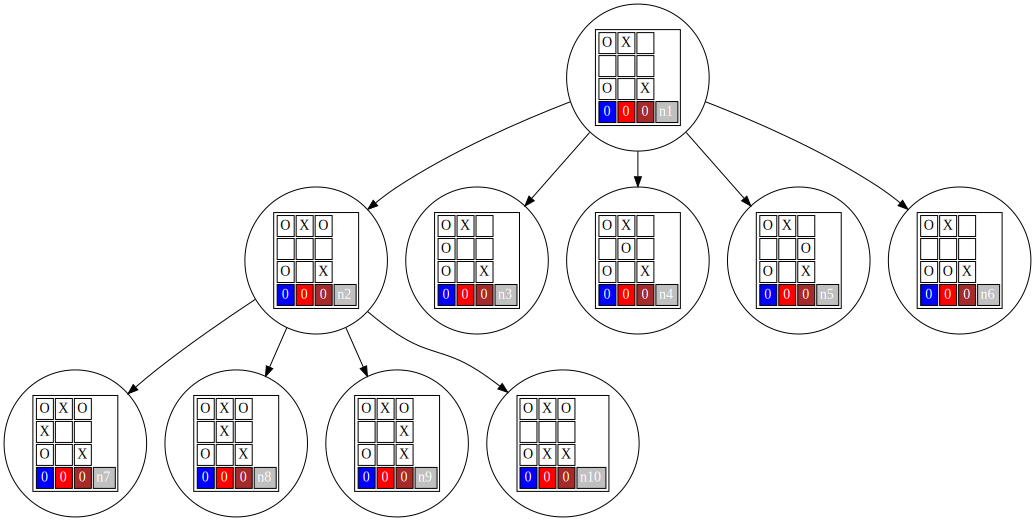

In [ ]:
ps

Função de busca em profundidade:

In [ ]:
def DFSIteration(ps, root):
  open = []
  closed = []
  open.append(root)

  while open:
    n = open.pop()

    if goal_find(n.matrix):
      return 'Success', printResults(n, open, closed, 'Profundidade')

    if game_winner(n.matrix, 'X'):
      continue

    moves, matrixs = possibleMoves(n.matrix, n.i, n.j, n.childTurn)

    z = 0
    childs = []
    for m in moves:
      tmp = Node(None, matrixs[z])
      tmp.create_node(ps)
      tmp.i = m[0]
      tmp.j = m[1]
      tmp.parent = n

      if n.childTurn == 'O':
        tmp.childTurn = 'X'
      else:
        tmp.childTurn = 'O'
      
      childs.append(tmp)
      open.append(tmp)
      z += 1
    
    closed.append(n)
    n.childs = childs
  
  return 'Fail'

In [ ]:
dfs = graphviz.Digraph('tic-tac-toe', comment='Tic-tac-toe solution tree', strict=True)
root2 = Node(None, board)
root2.create_node(dfs)
root2.i = 2
root2.j = 2
root2.childTurn = 'O'

start = time.time()
DFSIteration(dfs, root2)
end = time.time()
print("\nTIME: ", end - start)
timers['Profundidade'] = end-start

ABERTOS:
[['O', 'X', 'O'], ['', '', ''], ['O', '', 'X']] (n12), [['O', 'X', ''], ['O', '', ''], ['O', '', 'X']] (n13), [['O', 'X', ''], ['', 'O', ''], ['O', '', 'X']] (n14), [['O', 'X', ''], ['', '', 'O'], ['O', '', 'X']] (n15), [['O', 'X', 'X'], ['', '', ''], ['O', 'O', 'X']] (n17), [['O', 'X', ''], ['X', '', ''], ['O', 'O', 'X']] (n18), [['O', 'X', ''], ['', 'X', ''], ['O', 'O', 'X']] (n19), [['O', 'X', 'O'], ['', '', 'X'], ['O', 'O', 'X']] (n21), [['O', 'X', ''], ['O', '', 'X'], ['O', 'O', 'X']] (n22), [['O', 'X', 'X'], ['', 'O', 'X'], ['O', 'O', 'X']] (n24), 

FECHADOS:
[['O', 'X', ''], ['', '', ''], ['O', '', 'X']] (n11), [['O', 'X', ''], ['', '', ''], ['O', 'O', 'X']] (n16), [['O', 'X', ''], ['', '', 'X'], ['O', 'O', 'X']] (n20), [['O', 'X', ''], ['', 'O', 'X'], ['O', 'O', 'X']] (n23), [['O', 'X', ''], ['X', 'O', 'X'], ['O', 'O', 'X']] (n25), 

CAMINHO RESULTADO:
 --> [['O', 'X', 'O'], ['X', 'O', 'X'], ['O', 'O', 'X']] (26)
 --> [['O', 'X', ''], ['X', 'O', 'X'], ['O', 'O', 'X']] 

In [ ]:
connect_nodes(dfs, root2)

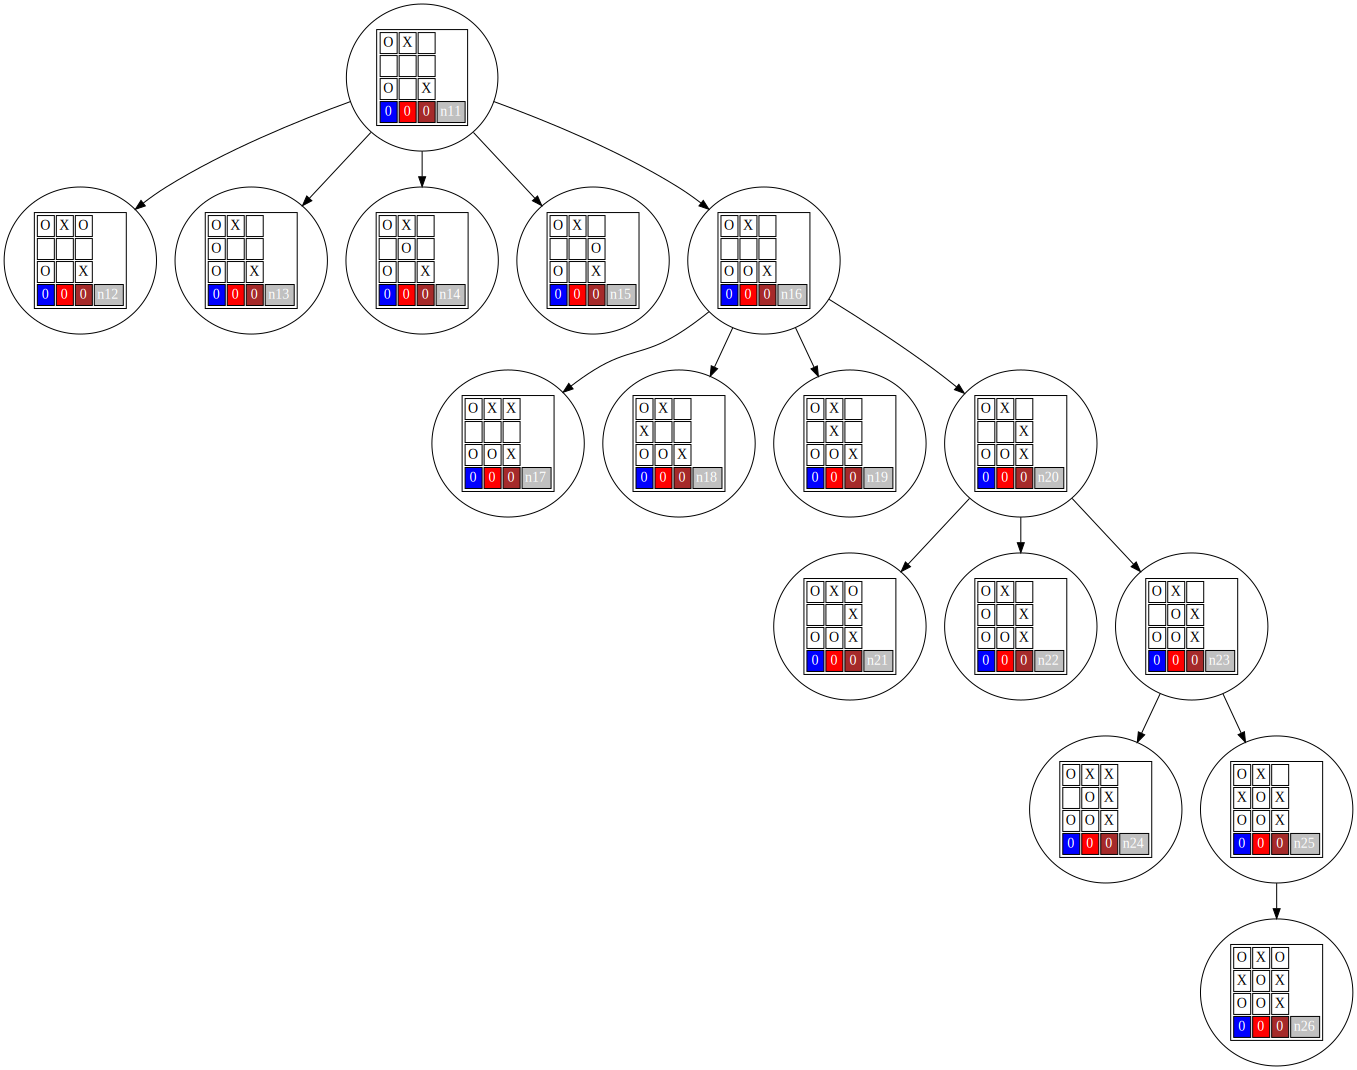

In [ ]:
dfs

Código para encontrar valores da função de heurística h(n). Aqui é considerado como heuristica o número de possibilidades de vitória de X subtraido pelo número de possibilidades de vitória de O.

In [ ]:
def empty_line(line):
  return line == ['', '', '']

def opp_symbol(symbol):
  if symbol == 'X':
    return 'O'
  else:
    return 'X'

def check_validity(ref, symbol):
  return symbol in ref and opp_symbol(symbol) not in ref

def heuristic_function(node):
  l = {'X': 0, 'O': 0}
  state = node.matrix

  for symbol, count in l.items():
    for index, line in enumerate(state):
      # Checking horizontal
      if empty_line(line):
        l[symbol] += 1

      # Checking X and O horizontal
      elif check_validity(line, symbol):
        l[symbol] += 1

      # Checking line vertical
      col = []
      for j in range(0, 3):
        col.append(state[j][index])

      if empty_line(col):
        l[symbol] += 1

      elif check_validity(col, symbol):
        l[symbol] += 1

    # Checking diagonal
    first = [state[0][0], state[1][1], state[2][2]]
    second = [state[0][2], state[1][1], state[2][0]]

    if check_validity(first, symbol) or empty_line(first):
      l[symbol] += 1

    if check_validity(second, symbol) or empty_line(second):
      l[symbol] += 1

  return l['X'] - l['O']

Realizando a busca gulosa baseado no valor de h(n) retornado. Quanto menor o valor de h(n), mais rapidamente este nó sera acessado na árvore, pois tende a escolher o nó onde O tem mais alternativas de vitória.

In [ ]:
def greedy_search(g, root):
  open = []
  closed = []
  open.append(root)

  while open:
    n = open.pop(0)

    if goal_find(n.matrix):
      return 'Success', printResults(n, open, closed, 'Gulosa')

    if game_winner(n.matrix, 'X'):
      continue

    moves, matrixs = possibleMoves(n.matrix, n.i, n.j, n.childTurn)

    z = 0
    childs = []
    for m in moves:
      tmp = Node(None, matrixs[z])
      tmp.heuristic = heuristic_function(tmp)
      tmp.create_node(g)
      tmp.i = m[0]
      tmp.j = m[1]
      tmp.parent = n

      if n.childTurn == 'O':
        tmp.childTurn = 'X'
      else:
        tmp.childTurn = 'O'

      childs.append(tmp)
      open.append(tmp)
      z += 1

    closed.append(n)
    n.childs = childs
    open.sort(key=lambda x: x.heuristic, reverse=False)

  return 'Fail'

In [ ]:
hs = graphviz.Digraph('tic-tac-toe', comment='Tic-tac-toe solution tree', strict=True)
root3 = Node(None, board)
root3.create_node(hs)
root3.i = 2
root3.j = 2
root3.childTurn = 'O'

start = time.time()
greedy_search(hs, root3)
end = time.time()
print("\nTIME: ", end - start)
timers['Gulosa'] = end-start

ABERTOS:
[['O', 'X', ''], ['', 'O', 'O'], ['O', 'X', 'X']] (n43), [['O', 'X', ''], ['', '', 'O'], ['O', 'X', 'X']] (n40), [['O', 'X', ''], ['O', 'O', ''], ['O', 'X', 'X']] (n42), [['O', 'X', 'O'], ['', '', ''], ['O', '', 'X']] (n28), [['O', 'X', ''], ['O', '', ''], ['O', '', 'X']] (n29), [['O', 'X', ''], ['', '', ''], ['O', 'O', 'X']] (n32), [['O', 'X', 'X'], ['', 'O', ''], ['O', '', 'X']] (n33), [['O', 'X', ''], ['', 'O', 'X'], ['O', '', 'X']] (n35), [['O', 'X', 'X'], ['', '', 'O'], ['O', '', 'X']] (n37), [['O', 'X', ''], ['X', 'O', ''], ['O', '', 'X']] (n34), [['O', 'X', ''], ['X', '', 'O'], ['O', '', 'X']] (n38), [['O', 'X', ''], ['', 'X', 'O'], ['O', '', 'X']] (n39), 

FECHADOS:
[['O', 'X', ''], ['', '', ''], ['O', '', 'X']] (n27), [['O', 'X', ''], ['', 'O', ''], ['O', '', 'X']] (n30), [['O', 'X', ''], ['', '', 'O'], ['O', '', 'X']] (n31), [['O', 'X', ''], ['', 'O', ''], ['O', 'X', 'X']] (n36), 

CAMINHO RESULTADO:
 --> [['O', 'X', 'O'], ['', 'O', ''], ['O', 'X', 'X']] (41)
 --> [[

In [ ]:
connect_nodes(hs, root3)

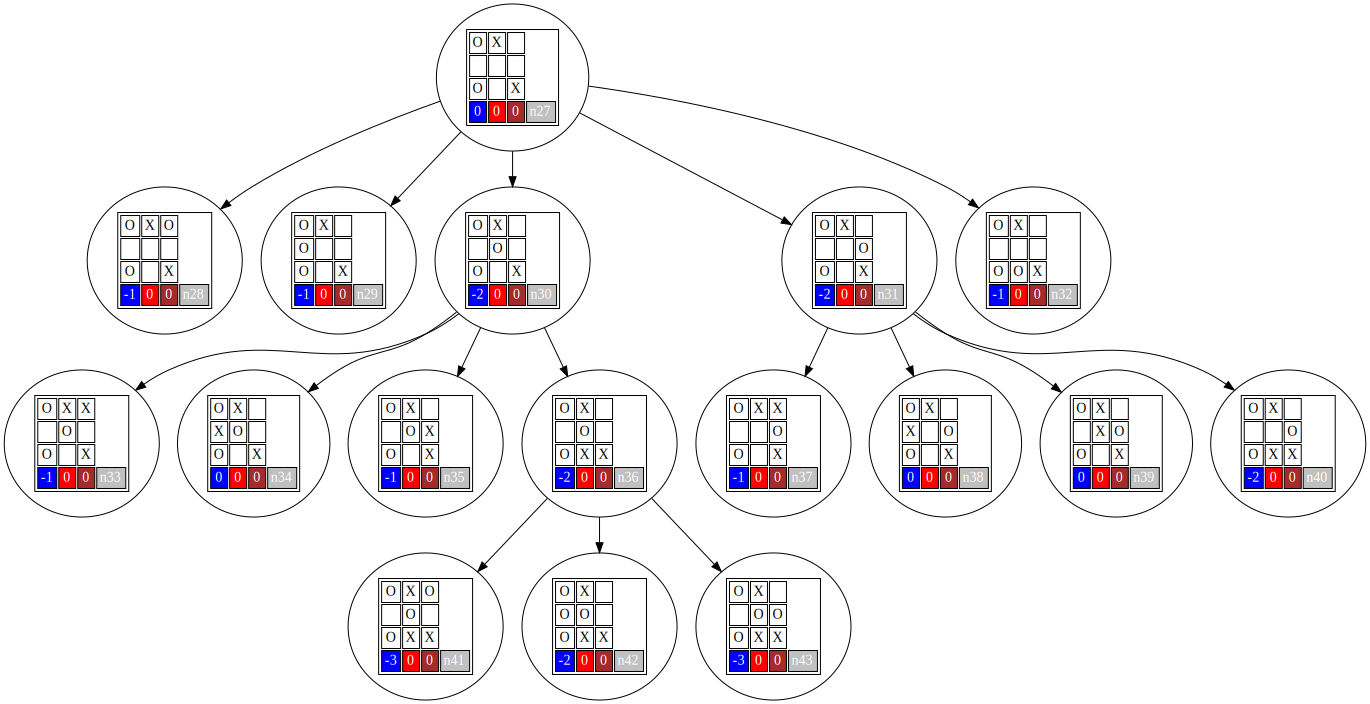

In [ ]:
hs

Função que encontra custo real g(n) para busca ordenada. Adiciona-se peso em caso de formar sequencias de linhas/colunas/diagonais:

In [ ]:
def count(l, turn):
  if check_validity(l, turn):
    if l.count(turn) == 2:
      return 1
    elif l.count(turn) == 3:
      return 2

  return 0

def weight(state, turn):
  peso = 0
  t = opp_symbol(turn)

  # Pesando linhas e colunas
  for i, line in enumerate(state):
    peso += count(line, t)
    peso += count([state[0][i], state[1][i], state[2][i]], t)

  # Pesando diagonais
  peso += count([state[0][0], state[1][1], state[2][2]], t)
  peso += count([state[0][2], state[1][1], state[2][0]], t)

  return peso

def cost_function(node):
  cost = 0 # custo da raíz até node
  s = node

  while True:
    s = s.parent

    if s != None:
      cost += 1
    else:
      break

  return cost + weight(node.matrix, node.childTurn)

Realizando busca ordenada baseado em g(n) e em nó mais antigo gerado:

In [ ]:
def ordenada_search(g, root):
  open = []
  closed = []
  open.append(root)

  while open:
    n = open.pop(0)

    if goal_find(n.matrix):
      return 'Success', printResults(n, open, closed, 'Ordenada')

    if game_winner(n.matrix, 'X'):
      continue

    moves, matrixs = possibleMoves(n.matrix, n.i, n.j, n.childTurn)

    z= 0
    childs = []
    for m in moves:
      tmp = Node(None, matrixs[z])
      tmp.heuristic = heuristic_function(tmp)
      tmp.parent = n
      tmp.i = m[0]
      tmp.j = m[1]

      if n.childTurn == 'O':
        tmp.childTurn = 'X'
      else:
        tmp.childTurn = 'O'

      tmp.cost = cost_function(tmp)
      tmp.create_node(g)
      childs.append(tmp)
      open.append(tmp)
      z += 1

    closed.append(n)
    n.childs = childs

    '''
    Tambem considera id_ref para ordenar visto que estamos interessados
    no custo menor do nó mais antigo
    '''
    open.sort(key=lambda x: (x.cost, -x.id_ref), reverse=True)

  return 'Fail'

In [ ]:
os = graphviz.Digraph('tic-tac-toe', comment='Tic-tac-toe solution tree', strict=True)
root4 = Node(None, board)
root4.cost = 0
root4.create_node(os)
root4.i = 2
root4.j = 2
root4.childTurn = 'O'

start = time.time()
ordenada_search(os, root4)
end = time.time()
print("\nTIME: ", end - start)
timers['Ordenada'] = end-start

ABERTOS:
[['O', 'X', ''], ['', 'O', ''], ['O', '', 'X']] (n47), [['O', 'X', 'O'], ['', 'X', ''], ['O', '', 'X']] (n51), [['O', 'X', 'O'], ['', '', ''], ['O', 'X', 'X']] (n53), [['O', 'X', ''], ['', '', 'O'], ['O', '', 'X']] (n48), [['O', 'X', ''], ['', '', ''], ['O', 'O', 'X']] (n49), [['O', 'X', 'O'], ['X', '', ''], ['O', '', 'X']] (n50), [['O', 'X', 'O'], ['', '', 'X'], ['O', '', 'X']] (n52), 

FECHADOS:
[['O', 'X', ''], ['', '', ''], ['O', '', 'X']] (n44), [['O', 'X', 'O'], ['', '', ''], ['O', '', 'X']] (n45), 

CAMINHO RESULTADO:
 --> [['O', 'X', ''], ['O', '', ''], ['O', '', 'X']] (46)
 --> [['O', 'X', ''], ['', '', ''], ['O', '', 'X']] (44)

TIME:  0.009517431259155273


In [ ]:
connect_nodes(os, root4)

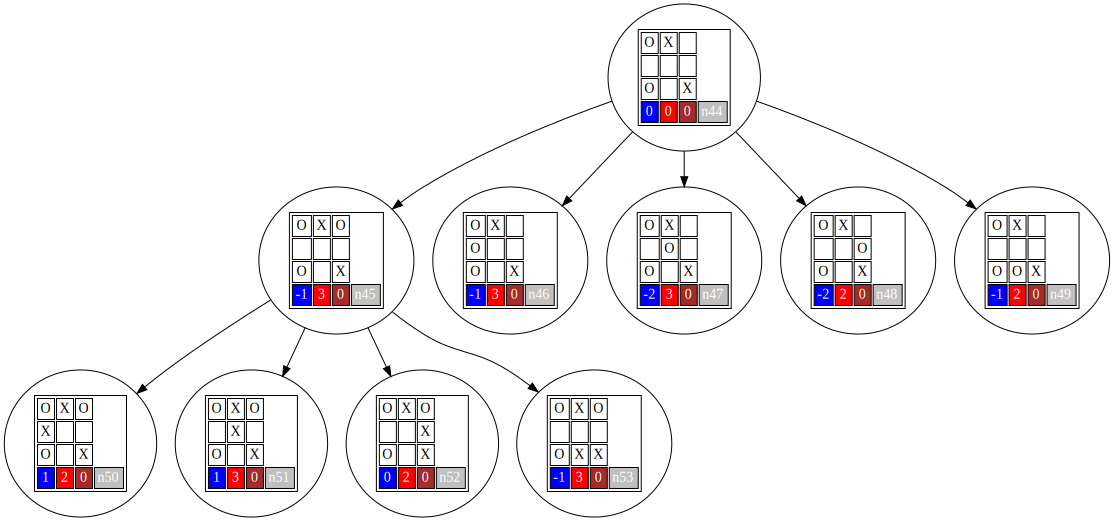

In [ ]:
os

Realizando busca A*:

In [ ]:
def astar_search(g, root):
  open = []
  closed = []
  open.append(root)

  while open:
    n = open.pop(0)

    if goal_find(n.matrix):
      return 'Success', printResults(n, open, closed, 'A*')

    if game_winner(n.matrix, 'X'):
      continue

    moves, matrixs = possibleMoves(n.matrix, n.i, n.j, n.childTurn)

    z= 0
    childs = []
    for m in moves:
      tmp = Node(None, matrixs[z])
      tmp.heuristic = heuristic_function(tmp)
      tmp.parent = n
      tmp.i = m[0]
      tmp.j = m[1]

      if n.childTurn == 'O':
        tmp.childTurn = 'X'
      else:
        tmp.childTurn = 'O'

      tmp.cost = cost_function(tmp)
      tmp.A = tmp.heuristic - tmp.cost
      tmp.create_node(g)
      childs.append(tmp)
      open.append(tmp)
      z += 1

    closed.append(n)
    n.childs = childs
    open.sort(key=lambda x: (x.A, x.id_ref), reverse=False)

  return 'Fail'

In [ ]:
astar = graphviz.Digraph('tic-tac-toe', comment='Tic-tac-toe solution tree', strict=True)
root5 = Node(None, board)
root5.cost = 0
root5.create_node(astar)
root5.i = 2
root5.j = 2
root5.childTurn = 'O'

start = time.time()
astar_search(astar, root5)
end = time.time()
print("\nTIME: ", end - start)
timers['A*'] = end-start

ABERTOS:
[['O', 'X', ''], ['', '', 'O'], ['O', '', 'X']] (n58), [['O', 'X', 'X'], ['', 'O', ''], ['O', '', 'X']] (n60), [['O', 'X', ''], ['', 'O', 'X'], ['O', '', 'X']] (n62), [['O', 'X', ''], ['', 'O', ''], ['O', 'X', 'X']] (n63), [['O', 'X', 'O'], ['', '', ''], ['O', 'X', 'X']] (n67), [['O', 'X', ''], ['', '', ''], ['O', 'O', 'X']] (n59), [['O', 'X', ''], ['X', 'O', ''], ['O', '', 'X']] (n61), [['O', 'X', 'O'], ['', 'X', ''], ['O', '', 'X']] (n65), [['O', 'X', 'O'], ['', '', 'X'], ['O', '', 'X']] (n66), [['O', 'X', 'O'], ['X', '', ''], ['O', '', 'X']] (n64), 

FECHADOS:
[['O', 'X', ''], ['', '', ''], ['O', '', 'X']] (n54), [['O', 'X', ''], ['', 'O', ''], ['O', '', 'X']] (n57), [['O', 'X', 'O'], ['', '', ''], ['O', '', 'X']] (n55), 

CAMINHO RESULTADO:
 --> [['O', 'X', ''], ['O', '', ''], ['O', '', 'X']] (56)
 --> [['O', 'X', ''], ['', '', ''], ['O', '', 'X']] (54)

TIME:  0.008683443069458008


In [ ]:
connect_nodes(astar, root5)

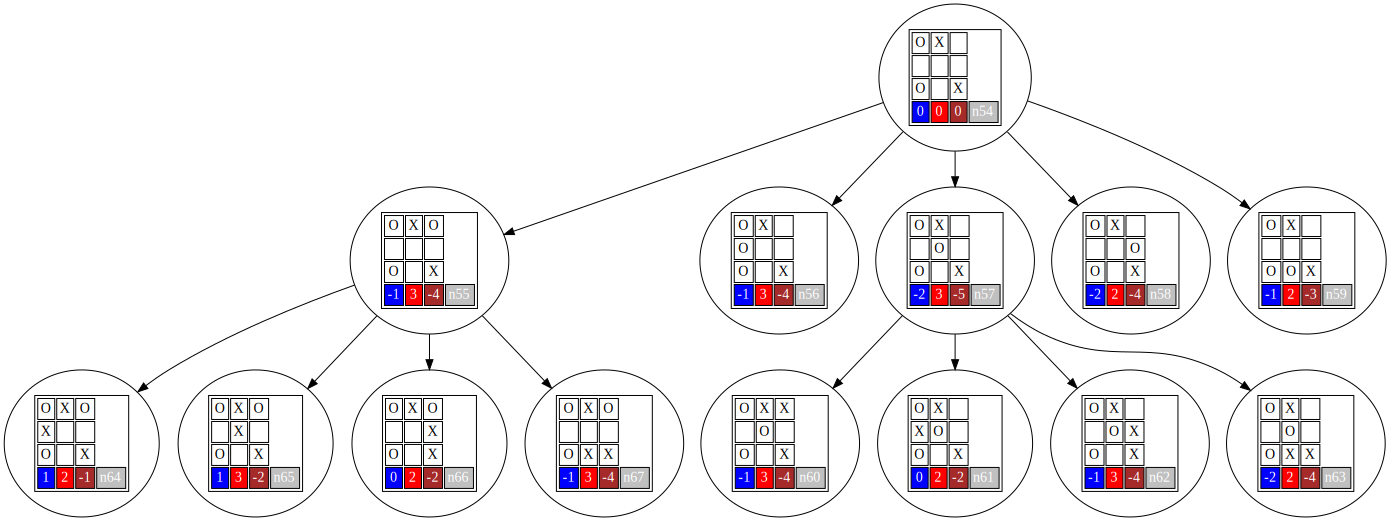

In [ ]:
astar

**Tempo de execução dos algoritmos**

In [ ]:
sorted_timers = sorted(timers.items(), key=lambda x: x[1])

for k, v in sorted_timers:
  print("{}: {}".format(k, v))

Largura: 0.001331329345703125
Gulosa: 0.006084442138671875
Profundidade: 0.00747370719909668
A*: 0.008683443069458008
Ordenada: 0.009517431259155273


Algoritmo mais veloz:

In [ ]:
print(sorted_timers[0][0])

Largura


**Distancia das soluções de cada algoritmo**

In [ ]:
sorted_alturas = sorted(alturas.items(), key=lambda x: x[1])

for k, v in sorted_alturas:
  print("{}: {}".format(k, v))

Largura: 1
Ordenada: 1
A*: 1
Gulosa: 3
Profundidade: 5


Algoritmo que encontrou solução em menor altura:

In [ ]:
try:
  first = sorted_alturas[0][1]
  idx = 0

  while(first == sorted_alturas[idx][1]):
    print("{}: {}".format(sorted_alturas[idx][0], sorted_alturas[idx][1]))
    idx += 1
except:
  print("Nenhuma solução foi encontrada. Exceção obtida.")

Largura: 1
Ordenada: 1
A*: 1


**Jogando contra a maquina**

In [ ]:
board = [['O', '', ''], ['', '', ''], ['', '', '']]

Setando funções que avaliam final de jogo

In [ ]:
def end_game(board):
  if game_winner(board, 'O'):
    return True

  if game_winner(board, 'X'):
    return True

  for line in board:
    for col in line:
      if col == '':
        return False

  return True

In [ ]:
def print_board(board):
  for line in board:
    print(line)

Para jogar, digite a posição (i, j) que deseja colocar o X. Inicialmente é utilizado o algoritmo de busca em largura, mas se for de interesse observar o comportamento da IA em outro, basta trocar a linha da chamada da função de busca (exemplo: BFSIteration).

In [ ]:
while not end_game(board):
  print_board(board)
  coord = input("Digite as coordenadas no formato -> i,j")
  i, j = [int(x) for x in coord.split(",")]
  board[i][j] = 'X'

  if(end_game(board)):
    break

  root = Node(None, board)
  root.create_node(ps)
  root.i = i
  root.j = j
  root.childTurn = 'O'

  # IA escolhe jogada
  res, path = BFSIteration(None, root)
  
  if res == 'Success':
    board = path[1]
  else:
    board = path.matrix
    print("Parece que a maquina não vai vencer você".format(board))

print("END GAME:\n")
print_board(board)

['O', '', '']
['', '', '']
['', '', '']
Digite as coordenadas no formato -> i,j2,2
ABERTOS:
[['O', 'O', 'O'], ['', 'O', 'X'], ['', 'X', 'X']] (n109), [['O', '', 'O'], ['O', 'O', 'X'], ['', 'X', 'X']] (n110), [['O', '', 'X'], ['', 'O', 'X'], ['O', '', 'X']] (n98), [['O', '', ''], ['X', 'O', 'X'], ['O', '', 'X']] (n99), [['O', '', ''], ['', 'O', 'X'], ['O', 'X', 'X']] (n100), [['O', 'O', ''], ['', 'O', 'X'], ['', 'X', 'X']] (n104), [['O', '', 'X'], ['', 'O', 'X'], ['', 'O', 'X']] (n106), [['O', '', ''], ['X', 'O', 'X'], ['', 'O', 'X']] (n107), [['O', '', ''], ['O', 'O', 'X'], ['', '', 'X']] (n90), [['O', '', 'O'], ['X', 'O', 'X'], ['', '', 'X']] (n94), [['O', '', 'O'], ['', 'O', 'X'], ['X', '', 'X']] (n95), [['O', 'X', ''], ['', 'O', 'X'], ['O', '', 'X']] (n97), [['O', 'O', 'X'], ['', 'O', 'X'], ['', '', 'X']] (n101), [['O', 'O', ''], ['X', 'O', 'X'], ['', '', 'X']] (n102), [['O', 'O', ''], ['', 'O', 'X'], ['X', '', 'X']] (n103), [['O', 'X', ''], ['', 'O', 'X'], ['', 'O', 'X']] (n105), [